# Using scikit-learn for topic modeling 10 newsgroups

Here we use scikit-learn to topic model a collection of 10 "newsgroups." (Think of a newsgroup as an old-fashioned 90s-era subreddit.)

We use a package called pyLDAvis that makes it possible to explore a model inside a Jupyter notebook.

Then we ask whether KMeans clustering better once the "dimensionality" of a text dataset has been reduced by topic modeling

In [47]:
import re
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler

# parts of this code are adapted from Ben Mabey's sklearn notebook
# here: https://github.com/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# You probably will need to run this before you can run the commands above.
# Uncomment the line below.

# !pip install pyLDAvis

## Fetching the data

Scikit-learn makes it possible for us to download the text of a standard dataset called "20 newsgroups."

Because this is a little large for a class exercise, we'll only download ten of them.

In [2]:
categories10 = ['alt.atheism', 'comp.graphics', 'comp.sys.mac.hardware', 'misc.forsale', 'rec.autos',
               'rec.sport.baseball', 'sci.med', 'sci.space', 'talk.politics.guns', 'talk.religion.misc']

newsgroups10 = fetch_20newsgroups(subset = 'train', categories = categories10, remove=('headers', 'footers', 'quotes'))

#### parts of the data

The newsgroup data comes with the raw texts, in a ```data``` attribute, and labels keyed to the categories we provided, in a ```target``` attribute.

In [3]:
docs_10 = newsgroups10.data

In [4]:
newsgroups10.target[0:10]

array([8, 6, 4, 2, 4, 0, 9, 8, 9, 1])

**let's check that these labels make sense**

The fourth element in that array (index #3 since counting starts at zero) is supposed to be topic ```comp.sys.mac.hardware.```

In [5]:
docs_10[3]

"Hello,\n  I just got some SIMMs,  at least one of which does not work. I don't know if \nthere is a software that can test SIMMs thoroughly or I could just rely on the \nRAM test performed by my computer during the start up. When I installed a dead \nSIMM into an LC or  an LC II, there would be a strange music and no display on \nthe screen. Why? I need your help! Thanks in advance"

Seems right!

## Vectorizing the data

First we need to transform the raw text into a term-document matrix.

In the past we've taken the "sparse matrix" output of the CountVectorizer and turned it into a readable Pandas dataframe, but that's not required here. In fact, the topic modeling function prefers to take a compressed / sparse version directly from the vectorizer.

In [154]:
vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 5)
docterms = vectorizer.fit_transform(docs_10)
print(docterms.shape)

(5528, 9129)


We have 5528 documents, and 9129 different "features" (words).

We're using a regular expression to tokenize the text. If you want to know what it does, you can copy ```\b[a-zA-Z]{3,}\b``` and take it to [https://regex101.com](https://regex101.com) to experiment.

```max_df``` and ```min_df``` select features by document frequency. Floats represent a proportion of documents; integers absolute counts. You can find [full documentation for CountVectorizer at the scikit-learn site.](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

## Topic modeling the data 

To produce a topic model, you have to specify the number of topics (```n_components```). 

If you look around online, you will find many different theories and rules of thumb about how to choose the "optimal" number of topics. Many websites will imply that there is some official way to guarantee that you have identified the correct answer. 

But people who are really familiar with topic modeling tend to say that there is no fixed answer to this question. The best number of topics can depend both on your research goal and on the size of the dataset. With very small datasets, it can be appropriate to choose 10 or 20 topics. Very large datasets are sometimes divided into 200 to 400 topics. But the choice may also depend on the *kind* of latent structure you're looking for in the corpus: are you interested in broad patterns or in granular details?

In this case, since we happen to know this dataset is constructed from about 10 different sources, it makes sense to use a number in that range. (Of course, you won't always know anything about the underlying structure. Also, as you'll see, topics are not guaranteed to line up perfectly with the categories a human reader might expect to see.)

In [155]:
lda = LatentDirichletAllocation(n_components=12, random_state=0, max_iter = 15)
lda.fit(docterms)

LatentDirichletAllocation(max_iter=15, n_components=12, random_state=0)

**How do we know whether we've done enough iterations?**

You can check the perplexity. As long as the perplexity keeps going down, the model is probably still getting better. The "perplexity" is calculated by estimating the likelihood of a set of documents given the model; if you don't have a held-out set, you can use the original training set. When the likelihood of the documents goes up, perplexity will go down.

Note, however, that perplexity does not provide a reliable way to compare models or choose the best number of topics. It just helps you judge when the model is converging. And in our classroom work, we're not even going to be very cautious about that, because we don't have time to wait for full convergence.

In [156]:
lda.perplexity(docterms)

3083.2903866769275

In [157]:
pyLDAvis.sklearn.prepare(lda, docterms, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.147056  0.042087       1        1  13.769016
7     -0.013534 -0.186915       2        1  13.273543
9     -0.119193  0.087075       3        1  11.989202
6     -0.196296 -0.030989       4        1  11.171141
4      0.140195 -0.167388       5        1  10.627523
8      0.188306  0.043227       6        1   8.360480
2      0.093619  0.153289       7        1   6.345024
11    -0.140168  0.056805       8        1   5.573594
10    -0.135156 -0.066774       9        1   5.239152
1      0.137460  0.159762      10        1   4.789785
5      0.152356 -0.093302      11        1   4.565801
0      0.039467  0.003121      12        1   4.295738, topic_info=           Term         Freq        Total Category  logprob  loglift
2611        edu  1176.000000  1176.000000  Default  30.0000  30.0000
7646      space  1092.000000  1092.000000  Default  29.0000  29.0000
1511        com   612.000000   612.000000  Default  28.0000  28.0000
3463        god   769.000000   769.000000  Default  27.0000  27.0000
3588        gun   631.000000   631.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
4618       left    44.990222   253.138223  Topic12  -5.8416   1.4201
6978      right    49.808890   738.333552  Topic12  -5.7399   0.4513
3200  following    43.646867   340.682647  Topic12  -5.8720   1.0927
4888        man    43.003366   284.457490  Topic12  -5.8868   1.2582
5936     person    42.352301   331.670825  Topic12  -5.9021   1.0894

[884 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         4  0.918160          aaa
0         8  0.030605          aaa
7         3  0.967120      abiding
33        2  0.972238  accelerator
111       2  0.967421      adapter
...     ...       ...          ...
9112      5  0.049738         york
9112      6  0.021316         york
9112      7  0.042633         york
9112      8  0.390802         york
9112     10  0.468963         york

[2760 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 10, 7, 5, 9, 3, 12, 11, 2, 6, 1])

## Extracting a document-topic matrix

We started out with a matrix that had one column for each term. Now that we've trained a topic model, we can produce a matrix that has one column for each topic.

In [158]:
doctopics = lda.transform(docterms)

In [159]:
doctopics.shape

(5528, 12)

## Try KMeans clustering on this doctopics matrix

Do KMeans clustering on *the doc-topic matrix,* (```doctopics```), with n_clusters = 10, to see how well we can reconstruct the divisions of the original dataset. 

There are (imperfect) ways to infer the number of clusters if you don't already know it, and we'll consider them in a moment. But for right now just use n_clusters = 10.

When you get a mapping of documents to clusters (in the ```.labels_``` attribute of the object returned by KMeans), compare it to the original newsgroup assignments using mutual information, to see how close they are.

I'll review mutual information in class, but basically you calculate it by considering the probability of all combinations of two sets of labels. Mutual information will be high if some combinations are much more likely or less likely than we would expect if the labels were independent.

The syntax of this measurement is ```mutual_info_score(one-list-of-labels, the-other-list-of-labels)```. This presumes that the two lists are the same length, and paired.

Then try the same thing doing KMeans clustering on *the document-term matrix* (```docterms```). How many clusters do you get? What's the mutual information with the original, ground-truth newsgroup assignments?


In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score
kmeans = KMeans(n_clusters=10, random_state=0).fit(doctopics)

In [45]:
pd.Series(kmeans.labels_).value_counts()

1    1112
0     875
5     753
2     588
4     555
7     474
8     348
9     306
3     270
6     247
dtype: int64

In [29]:
pd.Series(newsgroups10.target).value_counts()

5    597
4    594
6    594
7    593
3    585
1    584
2    578
8    546
0    480
9    377
dtype: int64

In [30]:
from sklearn.metrics import mutual_info_score

In [31]:
mutual_info_score(newsgroups10.target, kmeans.labels_)

0.8466794239281669

In [33]:
kmeans2 = KMeans(n_clusters=10, random_state=0).fit(dtm_10)
pd.Series(kmeans2.labels_).value_counts()

2    5475
0      37
9       8
5       2
4       1
8       1
1       1
6       1
3       1
7       1
dtype: int64

In [35]:
mutual_info_score(newsgroups10.target, kmeans2.labels_)

0.010094716118488884

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
components = pca.fit_transform(scaled_doctopics)  
components.shape

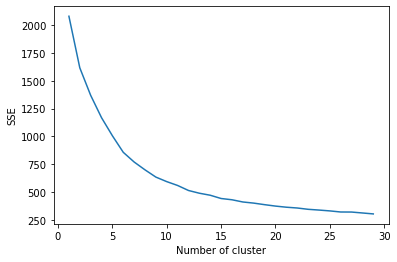

In [38]:
sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(doctopics)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

## Is it possible to infer the correct number of clusters?

In theory, but in practice it doesn't work as well as you might think.

One of the best ways is to compare a) the average distance between points *within* each cluster to b) the average distance *between* clusters. If b is bigger than a, the partitioning is probably strong.

Silhouette Score = (b-a)/max(a,b)

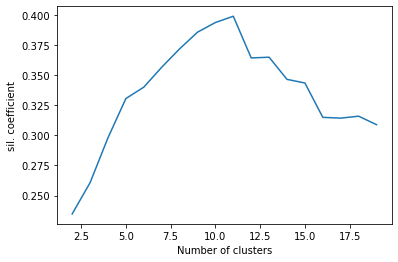

0.39890050613687367 11


In [152]:
# This code is based on Om Prakash's answer to this question
# on StackOverflow:
# https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

from sklearn.metrics import silhouette_score

silhouette_scores = []
n_cluster_vals = []

for n_cluster in range(2, 20):
    kmeans = KMeans(n_clusters=n_cluster, random_state = 0).fit(doctopics)
    label = kmeans.labels_
    sil_coeff = silhouette_score(doctopics, label, metric='euclidean')
    silhouette_scores.append(sil_coeff)
    n_cluster_vals.append(n_cluster)
    
plt.figure()
plt.plot(n_cluster_vals, silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("sil. coefficient")
plt.show() 

max_value = max(silhouette_scores)
print(max_value, n_cluster_vals[silhouette_scores.index(max_value)])

But note that this is more fragile than it appears. In this case, it looks like we're getting near the right value, but this is partly influenced by the number of topics we arbitrarily chose (12).

In [55]:
scaler = StandardScaler()
dtm_unsparse = dtm_10.toarray()
scaled_dtm = scaler.fit_transform(dtm_unsparse)

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
components = pca.fit_transform(scaled_dtm)  
components.shape

(5528, 2)

In [57]:
kmeans3 = KMeans(n_clusters=10, random_state=0).fit(components)
mutual_info_score(newsgroups10.target, kmeans3.labels_)

0.027742985248157548

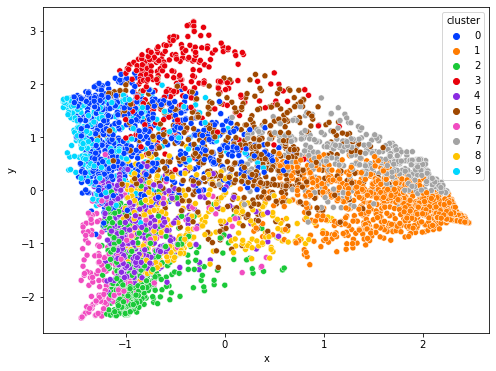

In [51]:
plt.figure(figsize=(8, 6))
plotframe = pd.DataFrame({'x': components[ : , 0], 'y': components[ : , 1], 'cluster': kmeans.labels_})
theplot = sns.scatterplot(data = plotframe, x = 'x', y = 'y', hue = 'cluster', palette = 'bright')

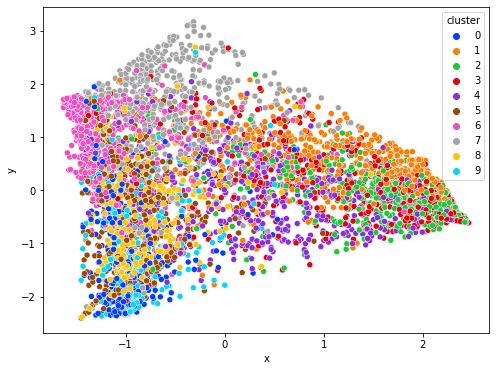

In [53]:
plt.figure(figsize=(8, 6))
plotframe = pd.DataFrame({'x': components[ : , 0], 'y': components[ : , 1], 'cluster': newsgroups10.target})
theplot = sns.scatterplot(data = plotframe, x = 'x', y = 'y', hue = 'cluster', palette = 'bright')

In [14]:
dt_df = pd.DataFrame(doc_topics)
dt_df.shape

(11314, 20)

In [16]:
dt_df['group'] = newsgroups.target

In [18]:
vectorbygroup = dt_df.groupby('group').agg('mean')
vectorbygroup.shape

(20, 20)

In [19]:
import seaborn as sns

<AxesSubplot:ylabel='group'>

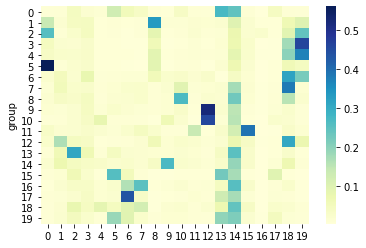

In [21]:
sns.heatmap(vectorbygroup, cmap="YlGnBu")

In [22]:
vectorbygroup.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
group,,,,,,,,,,,,,,,,,,,,
0,0.010428,0.011266,0.044176,0.018148,0.014440,0.126009,0.056290,0.037729,0.010556,0.007215,0.038327,0.012289,0.010529,0.274203,0.246109,0.011635,0.003963,0.043225,0.012583,0.010879
1,0.139515,0.019347,0.043452,0.044777,0.007572,0.011648,0.008167,0.009652,0.333390,0.013713,0.014768,0.017673,0.016603,0.019935,0.098542,0.020040,0.006933,0.007843,0.067183,0.099250
2,0.259277,0.012813,0.027118,0.046019,0.008031,0.009759,0.005662,0.009108,0.088087,0.007912,0.012947,0.019855,0.013048,0.014207,0.074967,0.019913,0.026086,0.008206,0.093484,0.243502
3,0.047712,0.020015,0.018137,0.030475,0.007028,0.008503,0.004707,0.006252,0.060508,0.005190,0.008166,0.013981,0.008767,0.016889,0.070545,0.028158,0.003473,0.004840,0.176792,0.459865
4,0.039018,0.027005,0.024758,0.031917,0.008095,0.007723,0.007922,0.005808,0.090988,0.007634,0.012386,0.013428,0.011364,0.013913,0.089493,0.026110,0.005679,0.006275,0.199283,0.371201


In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()
scaledtopics = scaler.fit_transform(vectorbygroup)

<AxesSubplot:>

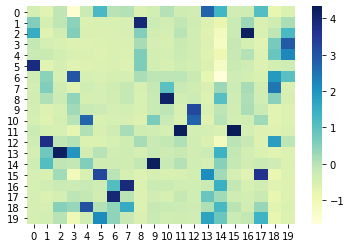

In [25]:
sns.heatmap(scaledtopics, cmap="YlGnBu")

In [26]:
categories10 = ['alt.atheism', 'comp.graphics', 'comp.sys.mac.hardware', 'misc.forsale', 'rec.autos',
               'rec.sport.baseball', 'sci.med', 'sci.space', 'talk.politics.guns', 'talk.religion.misc']

newsgroups10 = fetch_20newsgroups(subset = 'train', categories = categories10, remove=('headers', 'footers', 'quotes'))
 

In [28]:
newsgroups10.target[0:20]

array([8, 6, 4, 2, 4, 0, 9, 8, 9, 1, 1, 1, 7, 4, 8, 4, 1, 5, 8, 4])

In [34]:
docs_10 = newsgroups10.data

In [35]:
docs_10[5]

'\nOf course B.M. is not incorrect.  He is defending Islam.  When defending\nIslam against infidels you can say anything and no one will dare criticize\nyou.  But when an atheist uses the same argument he is using "petty sarcasm".  So\nB.M. can have his "temporary atheists" whenever he needs them and all the\n"temporary atheists" can later say that they were always good Muslims because\nthey never explicitly rejected Islam.  '

In [37]:
vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 5)
dtm_10 = vectorizer.fit_transform(docs_10)
print(dtm_10.shape)

(5528, 9129)


In [40]:
lda = LatentDirichletAllocation(n_components=12, random_state=0, max_iter = 50)
lda.fit(dtm_10)

LatentDirichletAllocation(max_iter=50, n_components=12, random_state=0)

In [41]:
pyLDAvis.sklearn.prepare(lda, dtm_10, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.234230 -0.045346       1        1  15.291405
3      0.159301  0.040325       2        1  13.754664
7      0.022071 -0.174888       3        1  12.667390
9      0.113459  0.109399       4        1  10.928321
4     -0.109488 -0.148462       5        1  10.353486
8     -0.156082  0.075877       6        1   8.034283
2     -0.110969  0.169282       7        1   6.082756
10     0.141510 -0.045758       8        1   4.973040
5     -0.152651 -0.189332       9        1   4.866700
1     -0.162830  0.124444      10        1   4.839974
11     0.084330  0.089436      11        1   4.181114
0     -0.062882 -0.004977      12        1   4.026867, topic_info=           Term         Freq        Total Category  logprob  loglift
7646      space  1099.000000  1099.000000  Default  30.0000  30.0000
2611        edu  1169.000000  1169.000000  Default  29.0000  29.0000
1511        com   609.000000   609.000000  Default  28.0000  28.0000
3463        god   768.000000   768.000000  Default  27.0000  27.0000
3588        gun   633.000000   633.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
4618       left    49.323450   252.420110  Topic12  -5.6851   1.5795
4888        man    49.130925   283.868805  Topic12  -5.6890   1.4582
3200  following    47.809820   340.620956  Topic12  -5.7162   1.2486
3390    general    45.982939   329.424414  Topic12  -5.7552   1.2431
6978      right    44.850348   738.808142  Topic12  -5.7801   0.4105

[846 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.960929       aaa
7         4  0.964360   abiding
13        7  0.036752  abortion
13       10  0.918803  abortion
29       10  0.935582   academy
...     ...       ...       ...
9112      6  0.014157      york
9112      7  0.028315      york
9112     10  0.495507      york
9112     11  0.396406      york
9116      8  0.968409     yount

[2277 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 8, 10, 5, 9, 3, 11, 6, 2, 12, 1])

There are different ways to implement Latent Dirichlet Allocation. Most of the implementations that you can load in a Jupyter notebook-- including the scikit-learn implementation--use "variational Bayes" sampling. That has the advantage of being fast. 

But there's pretty robust consensus among people who topic model a lot that "collapsed Gibbs" sampling produces slightly better results. If you're in a situation where you really care about details of the model, it might be worth looking up [a package called MALLET.](http://mallet.cs.umass.edu) This is written in Java and I normally run it from the command line, but there are also Python wrappers with MALLET if you don't want to mess with the command line.

In [63]:
poefic = pd.read_csv('/Users/tunder/Dropbox/courses/DH2019/lab1/data/poefic.csv')
poefic.head()

,date,author,title,genre,reception,text
0,1908,"Robins, Elizabeth,",The convert,fiction,elite,"looked like decent artisans, but more who bore..."
1,1871,"Lytton, Edward Bulwer Lytton,",The coming race,fiction,elite,"called the "" Easy Time "" (with which what I ma..."
2,1872,"Butler, Samuel,","Erewhon, or, Over the range",fiction,elite,the curtain ; on this I let it drop and retrea...
3,1900,"Barrie, J. M.",Tommy and Grizel,fiction,elite,"at you !"" he said. ""Dear eyes, "" said she. ""Th..."
4,1873,"Ritchie, Anne Thackeray,",Old Kensington,fiction,elite,"furious; I have not dared tell her, poor creat..."


In [120]:
def toint(aval):
    if len(aval) > 4:
        return int(aval[0:4])
    else:
        return int(aval)

poefic['intdate'] = poefic.date.apply(toint)

In [123]:
poefic.reception.value_counts()

elite       682
random      308
remove       28
addcanon      9
Name: reception, dtype: int64

In [104]:
documents = [x for x in poefic.text]

In [105]:
np.mean([len(x) for x in documents])

6374.198636806232

In [99]:
documents = []

for label, text in zip(newsgroups10.target, docs_10):
    if label in {3, 6, 7, 9}:
        documents.append(text)
len(documents)

2149

In [106]:
vector2 = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 5)
docvec = vector2.fit_transform(documents)
print(docvec.shape)

(1027, 11358)


In [124]:
lda2 = LatentDirichletAllocation(n_components=20, random_state=0, max_iter = 10)
lda2.fit(docvec)

LatentDirichletAllocation(n_components=20, random_state=0)

In [108]:
pyLDAvis.sklearn.prepare(lda2, docvec, vector2)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.131855 -0.006521       1        1  41.615865
1     -0.061413  0.003124       2        1  12.660218
8      0.100004  0.124174       3        1  10.004004
9     -0.186512  0.026521       4        1   9.204811
2     -0.167222  0.086820       5        1   8.184373
4      0.146902  0.098946       6        1   6.590378
7      0.057575 -0.185589       7        1   3.523308
5     -0.160155 -0.021683       8        1   2.275668
10     0.015588  0.034135       9        1   2.104563
0      0.084340  0.023409      10        1   1.866793
11     0.050828 -0.062154      11        1   1.032457
6     -0.011788 -0.121183      12        1   0.937563, topic_info=          Term         Freq        Total Category  logprob  loglift
10071      thy  3071.000000  3071.000000  Default  30.0000  30.0000
10005     thou  2015.000000  2015.000000  Default  29.0000  29.0000
9962      thee  1538.000000  1538.000000  Default  28.0000  28.0000
4271       god  1409.000000  1409.000000  Default  27.0000  27.0000
5394      king   437.000000   437.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
299      angel     7.940414   240.756955  Topic12  -6.2645   1.2578
2134   country     7.936351   273.146496  Topic12  -6.2650   1.1311
9153      soul     8.626453  1135.691119  Topic12  -6.1817  -0.2105
2416     death     8.225233   949.509572  Topic12  -6.2293  -0.0791
986      blood     7.930242   367.924117  Topic12  -6.2658   0.8324

[982 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
0          1  0.124225    aaron
0          2  0.559013    aaron
0          8  0.031056    aaron
0         11  0.248450    aaron
0         12  0.031056    aaron
...      ...       ...      ...
11343      9  0.022598    young
11343     10  0.010043    young
11343     11  0.003766    young
11351      1  0.426088  zealous
11351      8  0.532609  zealous

[3931 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 9, 10, 3, 5, 8, 6, 11, 1, 12, 7])

In [109]:
doctopics2 = lda2.transform(docvec)

In [110]:
scaler2 = StandardScaler()
unsparse = docvec.toarray()
scaled2 = scaler.fit_transform(unsparse)

In [111]:
pca = PCA(n_components = 2)
components = pca.fit_transform(scaled2)  
components.shape

(1027, 2)

In [112]:
kmeans4 = KMeans(n_clusters=2, random_state=0).fit(components)

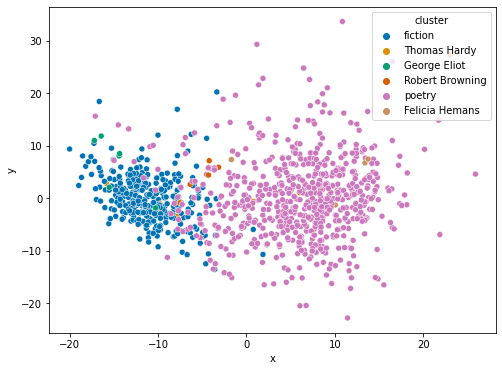

In [139]:
plt.figure(figsize=(8, 6))
plotframe = pd.DataFrame({'x': components[ : , 0], 'y': components[ : , 1], 'cluster': poefic.category})
theplot = sns.scatterplot(data = plotframe, x = 'x', y = 'y', hue = 'cluster', palette = 'colorblind')

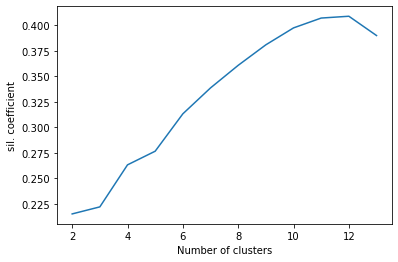

0.4088362927036655 12


In [103]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
n_cluster_vals = []

for n_cluster in range(2, 14):
    kmeans = KMeans(n_clusters=n_cluster, random_state = 0).fit(doctopics2)
    label = kmeans.labels_
    sil_coeff = silhouette_score(doctopics2, label, metric='euclidean')
    silhouette_scores.append(sil_coeff)
    n_cluster_vals.append(n_cluster)
    
plt.figure()
plt.plot(n_cluster_vals, silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("sil. coefficient")
plt.show() 

max_value = max(silhouette_scores)
print(max_value, n_cluster_vals[silhouette_scores.index(max_value)])

In [128]:
poefic.author.value_counts()[0:12]

Eliot, George,                8
MacDonald, George,            7
Fothergill, Jessie,           6
Browning, Robert,             6
Tennyson, Alfred Tennyson,    6
Yates, Edmund Hodgson,        6
Norton, Caroline Sheridan,    5
Black, William,               5
Hemans,                       5
<blank>                       5
Hardy, Thomas,                5
Gilder, Richard Watson,       4
Name: author, dtype: int64

In [136]:
def authornorm(row):
    auth = row['author']
    genre = row['genre']
    if auth == 'Eliot, George,':
        return 'George Eliot'
    elif auth == 'Browning, Robert,':
        return 'Robert Browning'
    elif auth == 'Hemans,':
        return "Felicia Hemans"
    elif auth == 'Hardy, Thomas,':
        return 'Thomas Hardy'
    else:
        return genre

authorcat = []
for idx, row in poefic.iterrows():
    authorcat.append(authornorm(row))

poefic['category'] = authorcat